### 統計學習與深度學習
### Homework 3


請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。


### 第一題 [分類器、特徵建構、與Stacking]

(50%) 建構分類器時常會透過特徵選擇與Ensemble增強預測能力。本題的目的是讓大家練習這些技巧。本題使用一個中文姓名分類的資料集。這個資料集收集了10730個中文名(不含姓)，以及這些名子對應到的性別。本資料集的資料檔是**namesex_data_v2.csv**，共有三個欄位，gname, sex, fold:
* gname: 不含姓的中文名。
* sex: 1為男性，0為女性。
* fold: 為0 - 9的整數，做為後續切割資料集使用。

我們先將這個資料集讀入Numpy Array，並列印前十筆資料。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

{'gname': '承憲', 'sex': '1', 'fold': '9'}
{'gname': '均平', 'sex': '1', 'fold': '7'}
{'gname': '思安', 'sex': '0', 'fold': '6'}
{'gname': '佑誠', 'sex': '1', 'fold': '3'}
{'gname': '乃馨', 'sex': '0', 'fold': '0'}
{'gname': '婕', 'sex': '0', 'fold': '0'}
{'gname': '冠瑜', 'sex': '0', 'fold': '1'}
{'gname': '冠學', 'sex': '1', 'fold': '0'}
{'gname': '立翰', 'sex': '1', 'fold': '2'}
{'gname': '以柔', 'sex': '0', 'fold': '6'}


接下來看一些統計數字:

In [2]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

資料筆數 =  10730


In [3]:
avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

男性比率 0.47940354147250697


這個資料集的男女比率還算是平均，男性佔了47.94%。

我們用了比較迂迴的方式讀檔案，Pandas其實可以直接讀csv檔。接下來做一些基本的資料分析。我們關心幾件事:
* 最常見的名子
* 共有多少個不重複的名子
* 有多少難判斷男女的名子

要回答這些問題，首先對名子加總，計算數量與男性比率，排序之後列出前20個名子:

In [4]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名子:")
sex_tend.head(20)

最常見的20個名子:


,name-,sex-mean,sex-count
3738,承恩,1.000000,20
918,冠廷,1.000000,20
2506,宜蓁,0.000000,18
545,佳穎,0.000000,16
3196,彥廷,0.923077,13
913,冠宇,1.000000,13
3390,思妤,0.000000,13
1019,凱翔,1.000000,13
3769,承翰,1.000000,13
3477,怡萱,0.000000,13


由上面的列表看來，最常見的男性名子是承恩與冠廷，最常見的女性名子是宜蓁與佳穎。而這些常見的名子男性比率都非常接近0或1，表示這些名子沒有性別混淆的問題。

另外一個問題是有多少名子只出現一次:

In [5]:
single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

出現一次名子個數:  7067 比率: 0.6586206896551724


由結果看來，名子在資料集中只出現一次的比率很高，有65%。也就是說，如果單純的使用訓練資料中出現的名子做為特徵，模型應該會有很差的預測能力。

#### <font color=#800000>為了處理這個問題，我們在接下來的任務中，會使用"Unigram + Full Name"的特徵表示，比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。</font>

最後我們來看看性別混淆的名子:

In [6]:
ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

難區分性別姓名數量:  136 比率: 0.012674743709226468


難以區分性別的名子總數並不高，所占總體資料的比率也很低，只有1.26%，因此不用擔心這個因素會影響預測準確率。

下面來看看幾個容易混淆性別的名子:

In [7]:
sex_amb.head()

,name-,sex-mean,sex-count
6777,育瑋,0.5,4
338,以恩,0.5,4
7783,郁軒,0.5,4
2513,宜謙,0.5,4
5920,祐嘉,0.5,4


#### 實做限制
為了確保可以確實練習到重要技巧，禁用Pycaret (<https://pycaret.org/>) 這類可以自動化調教參數與Ensemble模型的工具。另外也禁止使用`sklearn.ensemble.Stacking.*`。你可以使用sklearn中Pre-processing工具函數與現成的分類器，但參數調教請自行處理。



#### 回答下面問題
#### Q1.1 (10%): 
使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)。每個資料集應有特徵Array(二維)以及Label Array(一維)。如前面提到的，每個名子應該要對應到全名以及單字的One-hot Encoding。比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。建構特徵表示時應依照個特徵出現的頻率篩選。特徵在訓練資料出現兩次或以上才納入。如果一個特徵被排除，這個特徵出現時應被歸為"\_Other_Feature_"。任何名子只要有出現未被納入的特徵，則其"\_Other_Feature_"的欄位值為1。

舉例而言，假設訓練資料集中有下面三個名子: 承恩、承德、恩賜。在經過特徵頻率篩選之後，只剩下以下特徵: 承、恩。其他特徵，如承恩、承德、恩賜、德、賜皆被排除。因此最後的特徵表示為:

Input | 承 | 恩 | \_Other_Feature_ |
------|----|----|-----------------|
承恩  | 1  | 1   |  1    |
承德  | 1  | 0   |  1  |
恩賜  | 0  | 1   |  1 |

最後應產生以下Numpy Array:
* x_train: Training Features
* y_train: Training Labels
* x_valid: Validation Features
* y_valid: Validation Labels
* x_stack: Stack Features
* y_stack: Stack Labels
* x_test: Test Features
* y_test: Test Labels

請列出每個Numpy Array的Shape以資查驗。

In [89]:
x_train, y_train = [], []
x_valid, y_valid = [], []
x_stack, y_stack = [], []
x_test, y_test = [], []

for raw in range(len(list(foldlist))):
    if foldlist[raw] <= 6:
        x_train.append(list(namelist)[raw])
        y_train.append(list(sexlist)[raw])
    elif foldlist[raw] == 7:
        x_valid.append(list(namelist)[raw])
        y_valid.append(list(sexlist)[raw])
    elif foldlist[raw] == 8:
        x_stack.append(list(namelist)[raw])
        y_stack.append(list(sexlist)[raw])
    elif foldlist[raw] == 9:
        x_test.append(list(namelist)[raw])
        y_test.append(list(sexlist)[raw])

In [90]:
# length of name is either 1 or 2
for i in list(namelist):
    if len(i) > 2:
        print(i)

In [91]:
# build column list
d = {}
for name in list(namelist):
    if name not in d:
        d[name] = 1
    else:
        d[name] += 1

    if name[0] not in d:
        d[name[0]] = 1
    else:
        d[name[0]] += 1

    if len(name) == 2:
        if name[1] not in d:
            d[name[1]] = 1
        else:
            d[name[1]] += 1

col_list = []
for k,v in d.items():
    if v >= 2:
        col_list.append(k)

In [92]:
x_train2 = x_train
x_valid2 = x_valid
x_stack2 = x_stack
x_test2 = x_test

for data in [x_train2, x_valid2, x_stack2, x_test2]:
    xlist = []
    for name in data:
        raw = []
        for col in col_list:
            if len(col) == 1:
                if len(name) == 2:
                    if name[0] == col or name[1] == col: raw.append(1)
                    else: raw.append(0)
                else:
                    if name[0] == col: raw.append(1)
                    else: raw.append(0)
            else: # len(col) == 2
                if name == col: raw.append(1)
                else: raw.append(0)
        xlist.append(raw)

    if data is x_train2:
        x_train = np.array(xlist)
    elif data is x_valid2:
        x_valid = np.array(xlist)
    elif data is x_stack2:
        x_stack = np.array(xlist)
    elif data is x_test2:
        x_test = np.array(xlist)

In [106]:
x_test.sum()

2399

In [96]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_stack = np.array(y_stack)
y_test = np.array(y_test)

In [97]:
# print shape of numpy array
print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_valid.shape = {x_valid.shape}')
print(f'y_valid.shape = {y_valid.shape}')
print(f'x_stack.shape = {x_stack.shape}')
print(f'y_stack.shape = {y_stack.shape}')
print(f'x_test.shape = {x_test.shape}')
print(f'y_test.shape = {y_test.shape}')

x_train.shape = (7483, 2247)
y_train.shape = (7483,)
x_valid.shape = (1110, 2247)
y_valid.shape = (1110,)
x_stack.shape = (1073, 2247)
y_stack.shape = (1073,)
x_test.shape = (1064, 2247)
y_test.shape = (1064,)


#### Q1.2 (10%):
使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型。利用Training與Validation調教Regularization Coefficient $c$。Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)。將Training與Validation合併後，令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。注意應列出未取絕對值的係數數值，方知特徵的性別傾向。討論Prediction Performance與重要特徵的合理性。


In [123]:
# build list of grids
# r^19 = 10^7 -> r ~= 2.33
grid_list = []
a = 0.0001

for i in range(20):
    grid_list.append(a)
    a = a*2.33


將Regularization Coefficient C 設為grid值，max_iter設為1000，其他模型參數為預設值

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

f1_list = []
# grid search
for grid in grid_list:
    lr = LogisticRegression(C=grid, max_iter=1000)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_valid)
    f1_list.append(f1_score(y_valid, y_pred))

In [115]:
m = f1_list[0]
max_id = 0
for i in range(len(f1_list)):
    if f1_list[i] > m:
        m = f1_list[i]
        max_id = i

bestc = grid_list[max_id]
print(f'max f1 score: {f1_list[max_id]}')
print(f'bestc: {bestc}')

max f1 score: 0.9046270066100094
bestc: 0.47158416116442275


In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_TRAIN = np.concatenate([x_train, x_valid], axis=0)
Y_TRAIN = np.concatenate([y_train, y_valid])
lr = LogisticRegression(C=bestc, max_iter=1000)
lr.fit(X_TRAIN, Y_TRAIN)
y_pred = lr.predict(x_test)

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')


accuracy: 0.8787593984962406
precision: 0.849609375
recall: 0.893223819301848
f1 score: 0.8708708708708708


In [153]:
import itertools
coef_dict = {}
for i in range(len(list(lr.coef_[0]))):
    coef_dict[i] = list(lr.coef_[0])[i]

sort_coef = dict(sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True))
sort_coef = dict(itertools.islice(sort_coef.items(), 20))

rank = 1
for k,v in sort_coef.items():
    print(f'{rank}. {col_list[k]}: {v}')
    rank += 1

1. 妤: -3.1157841717601427
2. 萱: -2.7228529423507917
3. 婷: -2.699296239823123
4. 翔: 2.5295658081504016
5. 柔: -2.3479986450972126
6. 蓁: -2.321022799787531
7. 雅: -2.2366867637839105
8. 慈: -2.2312179326314436
9. 怡: -2.2078855672639537
10. 晴: -2.2025153293817175
11. 琳: -2.2007019827901764
12. 蓉: -2.1933342461282703
13. 涵: -2.1329838241049437
14. 婕: -2.1213498602233827
15. 潔: -2.1167633506579033
16. 傑: 2.115977268709217
17. 芸: -2.1005484790457105
18. 翰: 2.0950994616725707
19. 綺: -2.087273716889437
20. 姿: -2.052977556015845


係數絕對值的係數為負代表性別傾向偏女，正數則代表較偏男性，而前20大中除了「翔、傑、翰」，其他多為較女性化的字。從前面模型的f1 score分析可得知預估準確率達八成以上，模型表現良好，係數絕對值前20的結果也十分符合直覺，大多是看起來就很偏女性化的字，而且都只有一個字，沒有兩個字的名字出現。

#### Q1.3 (10%):
使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型。利用Training與Validation調教Number of Tress (i.e., n_estimators)。Grid Search的小值為$5$，最大值是$1,000$，總共取10個點，使用等比級數間隔。取F-1 Score最大之n_estimators，印出此數值(best_nest)。將Training與Validation合併後，令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [160]:
# build list of grids
# r^9 = 200 -> r ~= 2.33
grid_list3 = []
r = 5

for i in range(10):
    grid_list3.append(int(r))
    r = r*1.8

grid_list3

[5, 9, 16, 29, 52, 94, 170, 306, 550, 991]

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

f1_list3 = []
# grid search
for grid in grid_list3:
    rf = RandomForestClassifier(n_estimators=grid)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_valid)
    f1_list3.append(f1_score(y_valid, y_pred))

In [164]:
m = f1_list3[0]
max_id = 0
for i in range(len(f1_list3)):
    if f1_list3[i] > m:
        m = f1_list3[i]
        max_id = i

best_nest = grid_list3[max_id]
print(f'max f1 score: {f1_list3[max_id]}')
print(f'best_nest: {best_nest}')

max f1 score: 0.8692232055063913
best_nest: 9


In [165]:
X_TRAIN = np.concatenate([x_train, x_valid], axis=0)
Y_TRAIN = np.concatenate([y_train, y_valid])
rf = RandomForestClassifier(n_estimators=best_nest)
rf.fit(X_TRAIN, Y_TRAIN)
y_pred = rf.predict(x_test)

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')

accuracy: 0.8486842105263158
precision: 0.8196078431372549
recall: 0.8583162217659137
f1 score: 0.8385155466399197


In [171]:
coef_dict = {}
for i in range(len(list(rf.feature_importances_))):
    coef_dict[i] = list(rf.feature_importances_)[i]

sort_coef = dict(sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True))
sort_coef = dict(itertools.islice(sort_coef.items(), 20))

rank = 1
for k,v in sort_coef.items():
    print(f'{rank}. {col_list[k]}: {v}')
    rank += 1

1. 妤: 0.017757420647651078
2. 萱: 0.014151885947401459
3. 婷: 0.013816210158097968
4. 翔: 0.013200941120929073
5. 柏: 0.011705984396148833
6. 怡: 0.010172565937524964
7. 蓁: 0.009631971114019417
8. 雅: 0.00947962022269435
9. 哲: 0.009213187871711399
10. 佳: 0.009063800031142643
11. 芷: 0.008728143892411118
12. 承: 0.008296077341813137
13. 芸: 0.008272243177043427
14. 宜: 0.008185902805737201
15. 柔: 0.008013034747298566
16. 晴: 0.007950410430051225
17. 慈: 0.00784433200639297
18. 瑄: 0.007654100110708111
19. 庭: 0.007509421100963171
20. 翰: 0.007289748816621627


random forest分類器的feature_importances_能幫助我們了解每個特徵的重要性，撇除係數值，前四名的結果與Q1.2相同，前四名分別為「妤、萱、婷、翔」，而且大部分也是偏女性化的字上榜，但沒有正負號之分，所以無法看出對性別的影響方向。模型的f1 score大約為0.84，結合特徵重要性前20大來看，上榜的字都是直覺上容易判斷的性別的字，結果合理，模型表現良好。

#### Q1.4 (10%):
使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型。利用Training與Validation調教learning_rate與n_estimators。考慮以下Learning Rate: 0.1, 0.5, 1。每一個Learning Rate設n_estimator為1,500並估計一個GBDT分類器，計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值。對所有Learning Rate重複同樣程序，找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)。將Training與Validation合併後，令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [174]:
from sklearn.ensemble import GradientBoostingClassifier
gb1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1500)
gb1.fit(x_train, y_train)

gb2 = GradientBoostingClassifier(learning_rate=0.5, n_estimators=1500)
gb2.fit(x_train, y_train)

gb3 = GradientBoostingClassifier(learning_rate=1, n_estimators=1500)
gb3.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=1, n_estimators=1500)

Learning Rate = 0.1

In [182]:
stage_list1 = []
for pred in gb1.staged_predict(x_valid):
    stage_list1.append(f1_score(y_valid, pred))

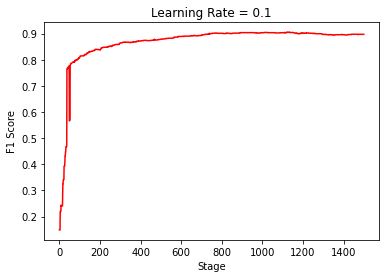

In [183]:
# plot the curve 
import matplotlib.pyplot as plt
plt.plot(stage_list1, color='red')
plt.xlabel('Stage')
plt.ylabel('F1 Score')
plt.title('Learning Rate = 0.1')
plt.show()

In [189]:
mx = stage_list1[0]
mx_id = 0

for i in range(len(stage_list1)):
    if stage_list1[i] > mx:
        mx = stage_list1[i]
        mx_id = i

print(f'stage {mx_id+1}: f1 score = {stage_list1[mx_id]}')

stage 1121: f1 score = 0.9050279329608938


Learning Rate = 0.5

In [186]:
stage_list2 = []
for pred in gb2.staged_predict(x_valid):
    stage_list2.append(f1_score(y_valid, pred))

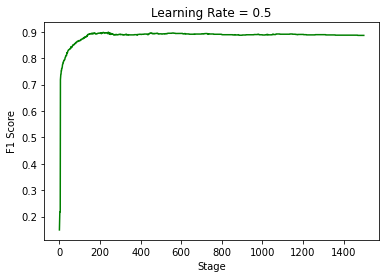

In [187]:
plt.plot(stage_list2, color='green')
plt.xlabel('Stage')
plt.ylabel('F1 Score')
plt.title('Learning Rate = 0.5')
plt.show()

In [190]:
mx = stage_list2[0]
mx_id = 0

for i in range(len(stage_list2)):
    if stage_list2[i] > mx:
        mx = stage_list2[i]
        mx_id = i

print(f'stage {mx_id+1}: f1 score = {stage_list2[mx_id]}')

stage 241: f1 score = 0.8980355472404116


Learning Rate = 1

In [191]:
stage_list3 = []
for pred in gb3.staged_predict(x_valid):
    stage_list3.append(f1_score(y_valid, pred))

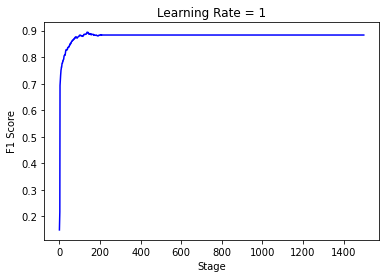

In [192]:
plt.plot(stage_list3, color='blue')
plt.xlabel('Stage')
plt.ylabel('F1 Score')
plt.title('Learning Rate = 1')
plt.show()

In [193]:
mx = stage_list3[0]
mx_id = 0

for i in range(len(stage_list3)):
    if stage_list3[i] > mx:
        mx = stage_list3[i]
        mx_id = i

print(f'stage {mx_id+1}: f1 score = {stage_list3[mx_id]}')

stage 137: f1 score = 0.8936567164179106


In [194]:
best_lr = 0.1
best_nstg = 1121
print(f'best_lr: {best_lr}, best_nstg: {best_nstg}')

best_lr: 0.1, best_nstg: 1121


Train the final model

In [196]:
X_TRAIN = np.concatenate([x_train, x_valid], axis=0)
Y_TRAIN = np.concatenate([y_train, y_valid])
gbf = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_nstg)
gbf.fit(X_TRAIN, Y_TRAIN)
y_pred = gbf.predict(x_test)

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')

accuracy: 0.868421052631579
precision: 0.8292220113851992
recall: 0.8973305954825462
f1 score: 0.8619329388560159


In [197]:
coef_dict = {}
for i in range(len(list(gbf.feature_importances_))):
    coef_dict[i] = list(gbf.feature_importances_)[i]

sort_coef = dict(sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True))
sort_coef = dict(itertools.islice(sort_coef.items(), 20))

rank = 1
for k,v in sort_coef.items():
    print(f'{rank}. {col_list[k]}: {v}')
    rank += 1

1. 妤: 0.02953220107033341
2. 翔: 0.02262987904153678
3. 萱: 0.019999867104929868
4. 柏: 0.01950225870002072
5. 婷: 0.01873040664238213
6. 怡: 0.012769500909635035
7. 哲: 0.012642153767291138
8. 承: 0.01260211544517303
9. 蓁: 0.012496603698711129
10. 雅: 0.011837292079748813
11. 晴: 0.011631832691963844
12. 佳: 0.011575668696489566
13. 柔: 0.01123981587556196
14. 宜: 0.011192810710850778
15. 涵: 0.010969407324246868
16. 芸: 0.010946416222523745
17. 芷: 0.010532987237164797
18. 瑄: 0.010440840945165803
19. 庭: 0.009997180322551492
20. 慈: 0.009880646377003985


與Q1.3相同，feature_importances_沒有正負號，無法看出特徵項對不同性別的影響程度，但我們一樣可從前20重要的特徵看到大部分都是偏女性化的字，而Q1.2和Q1.3一樣的前四名與Q1.4的不完全相同，前者為「妤、萱、婷、翔」，本小題的前四名則是「妤、翔、萱、柏」，「妤」一樣是第一名，「萱」跟「翔」同樣在前四名。本次模型f1 score為0.86，特徵係數前20大也同樣能夠很直覺地看出性別傾向，整體來說模型表現不錯，結果也很合理。

#### Q1.5 (10%):
取用前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree, 組合(Stacking)成一個新的分類器。我們使用Logistic Regression without Penalty建構這個Stacking分類器。訓練資料為Stacking資料集。各分類器輸入的特徵為男生預測機率(注意: 不是分類結果)。列出Stacking分類器的係數，討論係數的意義，並計算這個Stacking分類器在Test資料集的預測能力。

------
### Solution
1. 使用x_stack各自訓練三個base model，然後再用x_stack產生預測的機率值當做新的訓練資料。
2. 使用新的訓練資料訓練meta model，接著將x_test分別為入訓練好的三個base model，得到新的測試資料集
3. 預測新的測試資料集
------
請自行增加Cell並回答問題。

reference: https://www.yanxishe.com/blogDetail/15467

In [275]:
# Use stacking data to train 3 models (level 1)
lr_stack = LogisticRegression(C=bestc, max_iter=1000)
lr_stack.fit(x_stack, y_stack)
lr_ypred_stack = lr_stack.predict_proba(x_stack)
lr_ypred_test = lr_stack.predict_proba(x_test)

rf_stack = RandomForestClassifier(n_estimators=best_nest)
rf_stack.fit(x_stack, y_stack)
rf_ypred_stack = rf_stack.predict_proba(x_stack)
rf_ypred_test = rf_stack.predict_proba(x_test)

gb_stack = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_nstg)
gb_stack.fit(x_stack, y_stack)
gb_ypred_stack = gb_stack.predict_proba(x_stack)
gb_ypred_test = gb_stack.predict_proba(x_test)

In [276]:
# generate training and test data for meta model
x_meta_train = np.concatenate([lr_ypred_stack[:,1].reshape(x_stack.shape[0],1), rf_ypred_stack[:,1].reshape(x_stack.shape[0],1)], axis=1)
x_meta_train = np.concatenate([x_meta_train, gb_ypred_stack[:,1].reshape(x_stack.shape[0],1)], axis=1)
x_meta_test = np.concatenate([lr_ypred_test[:,1].reshape(x_test.shape[0],1), rf_ypred_test[:,1].reshape(x_test.shape[0],1)], axis=1)
x_meta_test = np.concatenate([x_meta_test, gb_ypred_test[:,1].reshape(x_test.shape[0],1)], axis=1)
x_meta_test.shape

(1064, 3)

In [277]:
# train logistic regression without penalty (level 2)
lr_meta = LogisticRegression(max_iter=1000, penalty='none')
lr_meta.fit(x_meta_train, y_stack)
meta_pred = lr_meta.predict(x_meta_test)

In [278]:
print(f'coef: {lr_meta.coef_}')
print(f'accuracy: {accuracy_score(y_test, meta_pred)}')
print(f'precision: {precision_score(y_test, meta_pred)}')
print(f'recall: {recall_score(y_test, meta_pred)}')
print(f'f1 score: {f1_score(y_test, meta_pred)}')

coef: [[-28.86367143  10.03542523  30.86275295]]
accuracy: 0.8204887218045113
precision: 0.8083333333333333
recall: 0.7967145790554415
f1 score: 0.8024819027921407


最後stacking分類器的係數分別代表三種base model對預測結果的影響程度，第三個模型（Gradient Boosting Decision Tree）影響程度最大，而且會使預測結果偏向男性。

## 第二題 [Data Visualization via Dimensionality Reduction]

Data visualization is a useful technique that can help us understand the characteristics of a dataset. We are going to practice this skill using the  University Offer of Admission Dataset (UDOAD).  

#### Dataset: University Department Offer of Admission Dataset (UDOAD; 大學推薦甄選資料集)

Many high school students get admitted to universities through an application and screening process that requires each university department to offer admission to applicants first before students can choose where they want to go. Suppose we think of applicants as the customers of an academic department. In that case, the duplications of offered applicants from different departments can be used to understand the competitive relationships between academic departments. We are going to visualize this competition relationship using UDOAD. 

UDOAD was collected through a popular online offer searching service (https://freshman.tw/; site no longer operational) for the 2017 academic year. We collected the offers received by each applicant as well as the basic information for academic departments. This dataset contains two files
* student_admission106.csv: the offers received by each student applicant. 
* univ_name106short1.csv: the basic information, such as the name and field of academic departments. 

Below is the first few records of these two files:

In [169]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("There are %d students and %d departments in total." % (nstuid, ndepid))

print("offers received by students:")
stu_adm.head(10)

There are 60461 students and 1976 departments in total.
offers received by students:


,school_id,department_id,student_id,student_name,state,location1,location2
0,001,001012,10246842,黃士玹,正1,南部,台南考區
1,001,001012,10042237,黃冠婷,正2,北部,台北考區
2,001,001012,10008031,鍾大方,正3,北部,台北考區
3,001,001012,10201525,曾信豪,正4,中部,彰化考區
4,001,001012,10014615,陳品儒,正5,北部,台北考區
5,001,001012,10294018,侯思筠,正6,東部,宜蘭考區
6,001,001012,10022810,吳悅慈,正7,北部,台北考區
7,001,001012,10236223,陳俞潔,正8,南部,台南考區
8,001,001012,10025909,蕭宇廷,正9,北部,台北考區
9,001,001012,10123708,吳岱軒,正10,北部,中壢考區


The department_id can uniquely identify an academic department. We do not care about the ranking of admission here, and you should ignore the "state" column. We only care about the "co-application" relations in this dataset. You should use student_id to identify a student applicant uniquely. 

In [170]:
print("academic department basic information:")
uname.head(10)

academic department basic information:


,year,school_id,department_id,school_name,department_name,category_id,category_name,school_name_abbr,department_name_abbr
0,106,006,006042,國立政治大學,教育學系,1,教育,政大,教育
1,106,006,006052,國立政治大學,教育學系(公費生),1,教育,政大,教育(公)
2,106,006,006062,國立政治大學,教育學系(原住民公費生),1,教育,政大,教育(原住民)
3,106,006,006022,國立政治大學,歷史學系,2,藝術及人文,政大,歷史
4,106,006,006152,國立政治大學,民族學系,2,藝術及人文,政大,民族學
5,106,006,006032,國立政治大學,哲學系,2,藝術及人文,政大,哲學
6,106,006,006262,國立政治大學,英國語文學系,2,藝術及人文,政大,英國語文
7,106,006,006292,國立政治大學,日本語文學系,2,藝術及人文,政大,日本語文
8,106,006,006272,國立政治大學,阿拉伯語文學系,2,藝術及人文,政大,阿拉伯語文
9,106,006,006302,國立政治大學,韓國語文學系,2,藝術及人文,政大,韓國語文


You can use this dataset to identify the name of a department_id. The school_name and department_name contain the "full name" of an academic department. To facilitate visualization, we also provide "shorter names" in school_name_abbr and department_name_abbr. The category_name is the field of an academic department. This field is essential in our visualization exercise since you should color each data point according to its category_name. 

#### Implementation Restrictions
You are allowed to use any Python libraries in your solution. 

### Data Preparation
Our focus is on the relationships between departments. To do this, we need to convert the raw data into a "matrix" representation. Each row represents an academic department, and each column represents a student applicant. The cell's value is one if a student applied for admission to the corresponding academic department, and 0 otherwise. 

To avoid potential numerical problems, we only include an academic department if it received ten or more applications. Moreover, we only include a student applicant if he or she applied for more than one academic department. 

Note that the two conditions should be satisfied "as is" in after preprocessing. For example, suppose a student applied for two departments in the original dataset, and one of the departments was removed. In that case, this student should be removed because the student only applied for one department in the processed dataset. 



In [171]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


Report the number of academic departments and student applicants in the processed dataset: 

In [172]:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

In final dataset, there are 1917 academic departments and 47386 student applicants.


Report the top ten departments that received the most applications and the number of applications they received:

In [173]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [174]:
topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
topdep

,department_id,department_name,num_applicant
0,008122,中原機械工程學,386.0
1,012052,中醫藥學,376.0
2,046032,銘傳會計（臺北）,367.0
3,004382,成大電機,357.0
4,005192,東吳企業管理,353.0
5,008112,中原土木,353.0
6,005182,東吳會計,351.0
7,015342,逢甲財金,340.0
8,045012,義守電機,339.0
9,046162,銘傳應用英語（桃園）,329.0


### Answer the following questions
Visualize academic departments in the following questions. In all plots, you should color data points according to the academic department's category. Moreover, you should provide a legend or a picture that illustrates the mapping between colors and category names. Visualize the data using two-dimensional plots. Note that it is your responsibility to study the documentation of your choice libraries and make sure that the results are reasonable. 
* Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 
* Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 
* Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 
* Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 
* Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 
* Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

---
### Solution
---

Add cells below and answer the questions below.